In [1]:
import re
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams["figure.figsize"] = (11, 6) 

In [2]:
!curl https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv -o data/housing.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1390k  100 1390k    0     0  1557k      0 --:--:-- --:--:-- --:--:-- 1560k


In [3]:
PATH = "data/housing.csv"
select_cols = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "median_house_value", "ocean_proximity"]
df = pd.read_csv(PATH, usecols=select_cols)

## Loading the data

Use only the following columns:  
* `'latitude'`,
* `'longitude'`,
* `'housing_median_age'`,
* `'total_rooms'`,
* `'total_bedrooms'`,
* `'population'`,
* `'households'`,
* `'median_income'`,
* `'median_house_value'`,
* `'ocean_proximity'`  

* Fill NAs with 0.
* Apply the log tranform to `median_house_value`.
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer` to turn the dataframe into matrices.

---
## Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?

* `ocean_proximity=INLAND`
* `total_rooms`
* `latitude`
* `population`
---

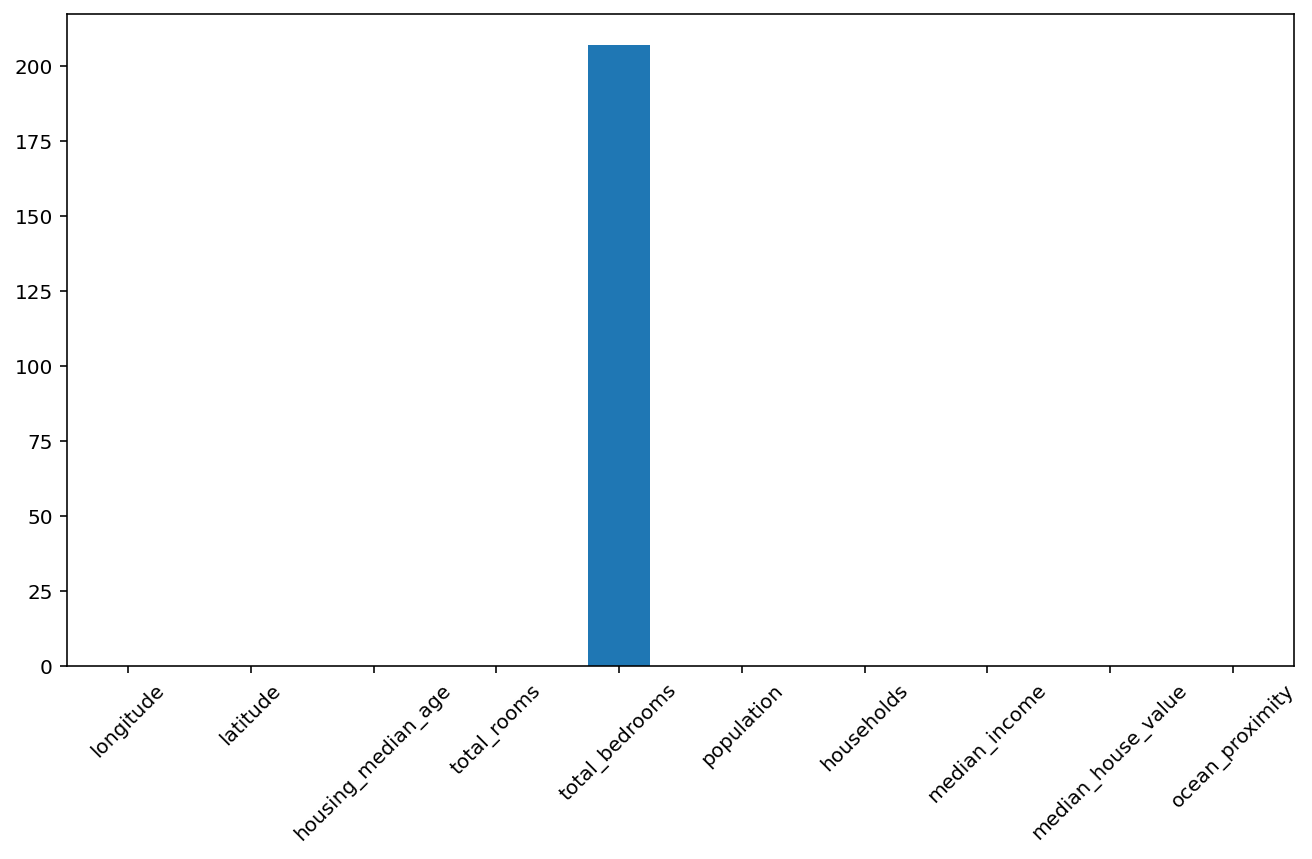

In [4]:
df.isna().sum().plot(kind='bar', rot=45);

In [5]:
df["total_bedrooms"].fillna(0, inplace=True)

In [6]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


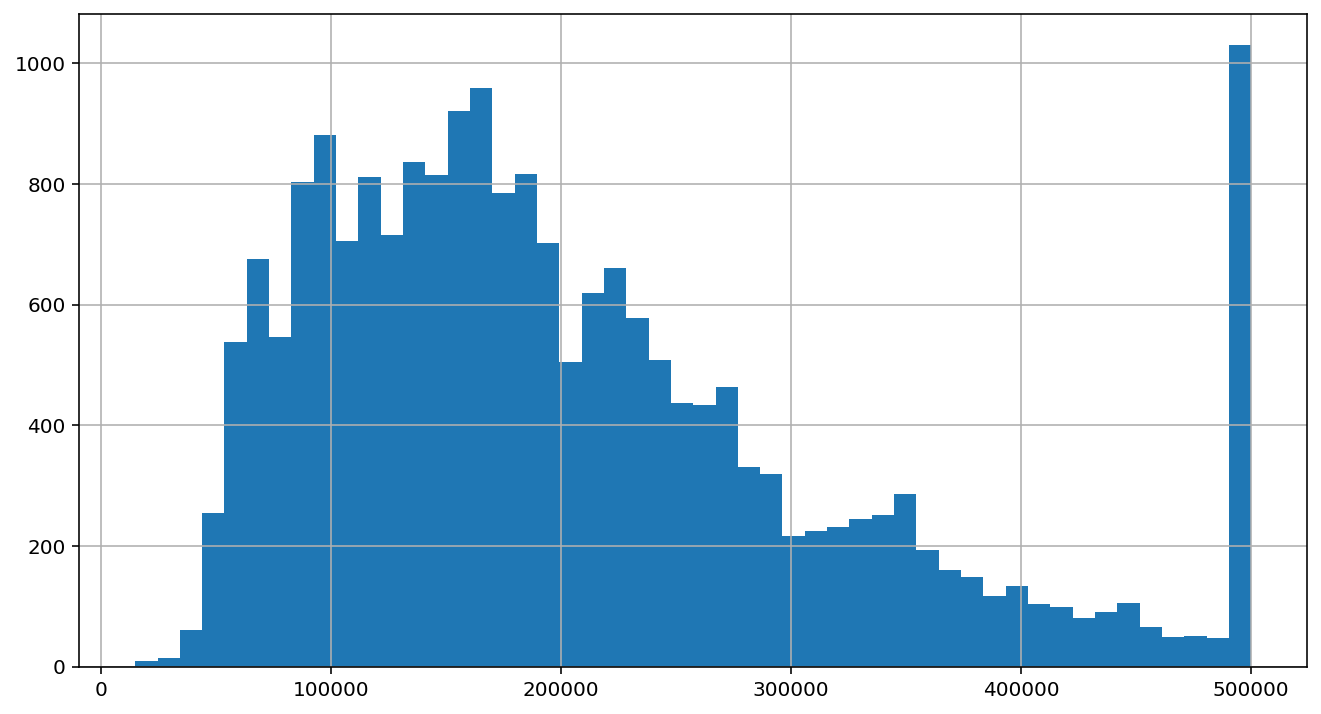

In [7]:
df["median_house_value"].hist(bins=50);

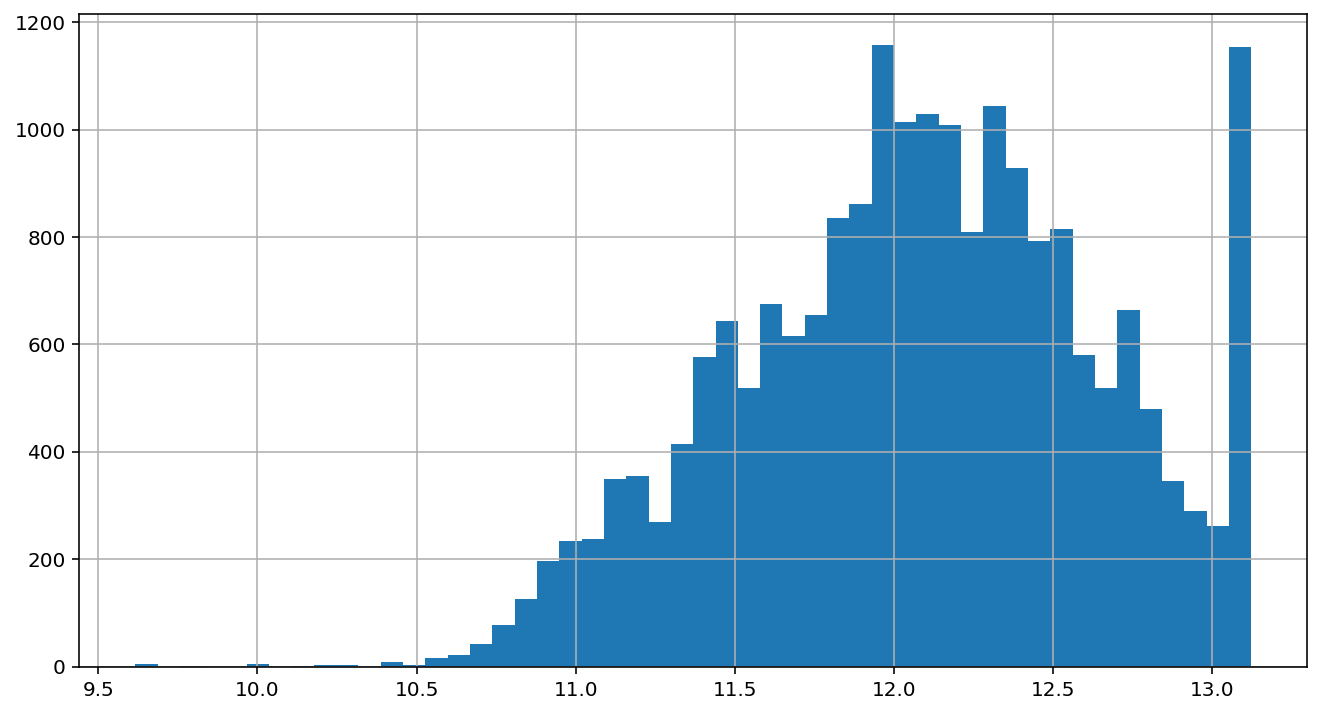

In [8]:
df["median_house_value"] = np.log(df["median_house_value"])
df["median_house_value"].hist(bins=50);

In [9]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_valid = train_test_split(df_full_train, test_size=0.25, random_state=1)
df_full_train.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
15961,-122.43,37.71,52.0,1410.0,286.0,879.0,282.0,3.1908,12.451369,NEAR BAY
1771,-122.35,37.95,42.0,1485.0,290.0,971.0,303.0,3.6094,11.649203,NEAR BAY
16414,-121.24,37.90,16.0,50.0,10.0,20.0,6.0,2.6250,11.831379,INLAND


In [10]:
y_full_train = df_full_train.median_house_value
y_train = df_train.median_house_value
y_valid = df_valid.median_house_value
y_test = df_test.median_house_value

df_full_train = df_full_train.drop("median_house_value", axis="columns").reset_index(drop=True)
df_train = df_train.drop("median_house_value", axis="columns").reset_index(drop=True)
df_valid = df_valid.drop("median_house_value", axis="columns").reset_index(drop=True)
df_test = df_test.drop("median_house_value", axis="columns").reset_index(drop=True)

In [11]:
df_full_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-122.43,37.71,52.0,1410.0,286.0,879.0,282.0,3.1908,NEAR BAY
1,-122.35,37.95,42.0,1485.0,290.0,971.0,303.0,3.6094,NEAR BAY
2,-121.24,37.90,16.0,50.0,10.0,20.0,6.0,2.6250,INLAND
3,-118.35,34.02,34.0,5218.0,1576.0,3538.0,1371.0,1.5143,<1H OCEAN
4,-118.39,33.89,38.0,1851.0,332.0,750.0,314.0,7.3356,<1H OCEAN


In [12]:
dv = DictVectorizer(sparse=False)
train_dict = df_train.to_dict(orient= 'records')
valid_dict = df_valid.to_dict(orient= 'records')
test_dict = df_test.to_dict(orient= 'records')
X_train = dv.fit_transform(train_dict)
X_valid = dv.transform(valid_dict)
X_test = dv.transform(test_dict)

In [13]:
feat_names = list(dv.get_feature_names_out())
print(feat_names)

['households', 'housing_median_age', 'latitude', 'longitude', 'median_income', 'ocean_proximity=<1H OCEAN', 'ocean_proximity=INLAND', 'ocean_proximity=ISLAND', 'ocean_proximity=NEAR BAY', 'ocean_proximity=NEAR OCEAN', 'population', 'total_bedrooms', 'total_rooms']


In [14]:
dtr = DecisionTreeRegressor(max_depth=1)
dtr.fit(X_train, y_train)
print(export_text(dtr, feature_names=feat_names))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



We can conclude that ocean_proximity=INLAND is the best feature for a decision stump.

---
## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)


What's the RMSE of this model on validation?

* 0.05
* 0.25
* 0.55
* 0.85
---

In [15]:
rfr = RandomForestRegressor(n_estimators= 10, random_state=1, n_jobs=-1)

rfr.fit(X_train, y_train)
y_val_pred = rfr.predict(X_valid)
rf_rmse_val = np.sqrt(mean_squared_error(y_valid, y_val_pred)).round(2)

print(f"Random Forest with n_estimators=10 has validation rmse: {rf_rmse_val}")

Random Forest with n_estimators=10 has validation rmse: 0.25


---
## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?

- 10
- 55
- 75
- 150
---

In [16]:
scores = {}
for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor( n_estimators = n, random_state = 1, n_jobs = -1 )
    rf.fit(X_train, y_train)
    y_val_pred = rf.predict(X_valid)
    rmse_val = np.sqrt(mean_squared_error(y_valid, y_val_pred))
    scores[n] = rmse_val

  0%|          | 0/20 [00:00<?, ?it/s]

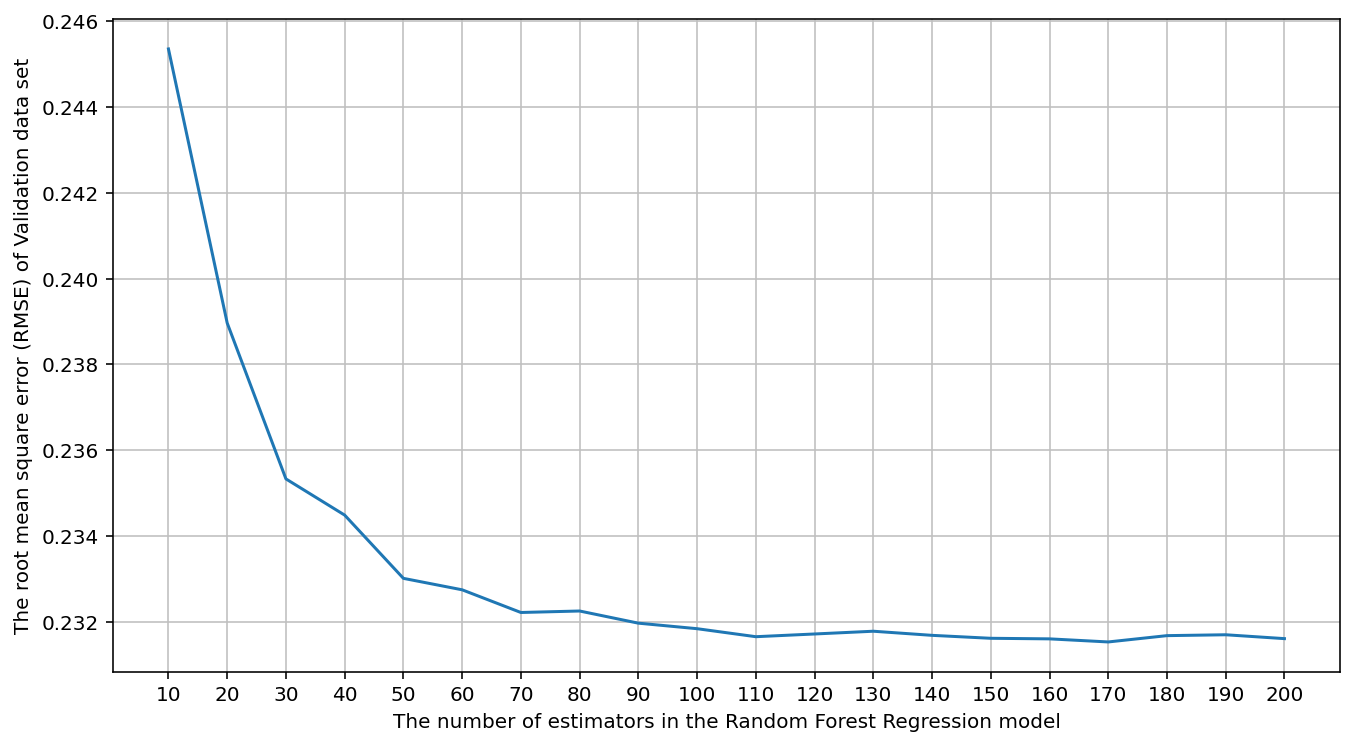

In [17]:
plt.plot(scores.keys(), scores.values())
plt.xlabel("The number of estimators in the Random Forest Regression model")
plt.ylabel("The root mean square error (RMSE) of Validation data set")
plt.grid(color='0.75')
plt.xticks(ticks=np.arange(10, 201, 10))
plt.show()

We can see that the first plateau occurs around the boosting round of 70-80.

---
## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`


What's the best `max_depth`:

* 10
* 15
* 20
* 25
---

In [18]:
scores = {}

for max_depth in tqdm([10, 15, 20, 25]):
    for n in range(10, 201, 10):
        rf = RandomForestRegressor( n_estimators=n, max_depth=max_depth, random_state=1, n_jobs=-1 )
        rf.fit(X_train, y_train)
        y_val_pred = rf.predict(X_valid)
        rmse_val = np.sqrt(mean_squared_error(y_valid, y_val_pred))
        scores[max_depth] = scores.get(max_depth, []) + [rmse_val]

  0%|          | 0/4 [00:00<?, ?it/s]

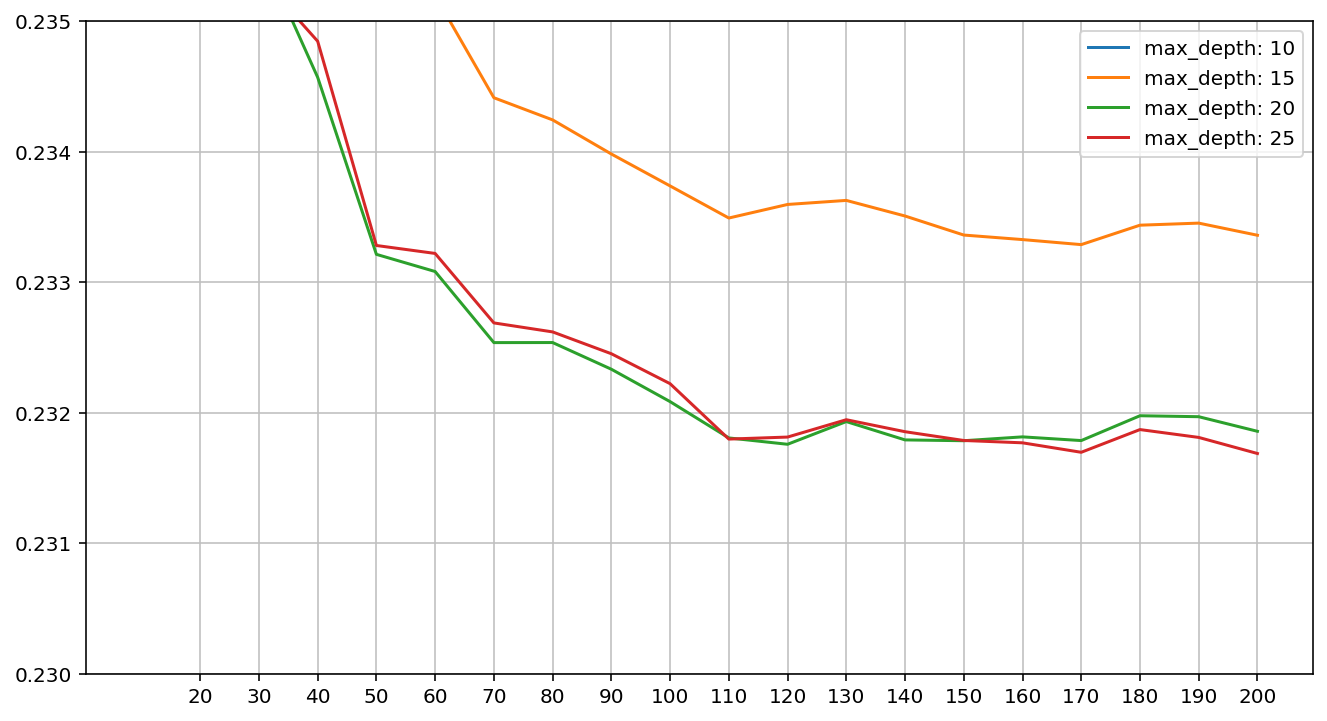

In [19]:
for md in [10, 15, 20, 25]:
    plt.plot(range(10, 201, 10), scores[md], label="max_depth: %s"%md)
plt.legend()
plt.ylim(0.230, 0.235)
plt.grid(color='0.75')
plt.xticks(ticks=np.arange(20, 201, 10))
plt.show()

Here, max_depth values of 20 and 25 are almost the same, but 25 gives a slightly better score.

---
## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature? 

* `total_rooms`
* `median_income`	
* `total_bedrooms`
* `longitude`
---

In [20]:
rf = RandomForestRegressor( n_estimators=10, max_depth=20, random_state=1, n_jobs=-1 )
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [21]:
feat_importance_df = pd.DataFrame(zip(feat_names, rf.feature_importances_), columns=["feature_name", "feature_importance"])
feat_importance_df.sort_values("feature_importance", ascending=False)

,feature_name,feature_importance
4,median_income,0.363890
6,ocean_proximity=INLAND,0.310901
2,latitude,0.100636
3,longitude,0.096873
1,housing_median_age,0.032923
10,population,0.030010
12,total_rooms,0.020914
11,total_bedrooms,0.019050
0,households,0.016888
9,ocean_proximity=NEAR OCEAN,0.004220


In [22]:
feat_importance_df[feat_importance_df.feature_importance== max(feat_importance_df.feature_importance)]

,feature_name,feature_importance
4,median_income,0.36389


---
## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* Both gives same
---

In [23]:
# Here we need to get rid of "<[]" chars or XGB complains
feat_names

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=<1H OCEAN',
 'ocean_proximity=INLAND',
 'ocean_proximity=ISLAND',
 'ocean_proximity=NEAR BAY',
 'ocean_proximity=NEAR OCEAN',
 'population',
 'total_bedrooms',
 'total_rooms']

In [24]:
regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) 
                                else col 
                                for col in feat_names]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dvalid = xgb.DMatrix(X_valid, label=y_valid, feature_names=features)

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

watchlist = [(dtrain, 'train'),(dvalid, 'valid')]

In [25]:
%%capture output1
model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

In [26]:
def parseXGBoutput(s):
    s = str(s.stdout.strip())
    lines = s.split("\n")
    num_boost = []
    train_rmse = []
    valid_rmse = []
    for line in lines:
        values = line.split('\t')
        n = values[0]
        tr = values[1]
        vl = values[2]
        num_boost.append(n.strip("[]"))
        train_rmse.append(float(tr.split(':')[-1]))
        valid_rmse.append(float(vl.split(':')[-1]))
    
    xgb_df = pd.DataFrame(zip(num_boost, train_rmse, valid_rmse), columns=["boost_number","train_rmse","valid_rmse"])
    return xgb_df

xgb_results = parseXGBoutput(output1)
xgb_results.head()

,boost_number,train_rmse,valid_rmse
0,0,8.12733,8.13244
1,5,1.40218,1.40740
2,10,0.34481,0.35782
3,15,0.23575,0.26099
4,20,0.21461,0.24532


In [27]:
#add eta value to the dataframe
xgb_results['eta'] = xgb_params["eta"]
xgb_results.head()

,boost_number,train_rmse,valid_rmse,eta
0,0,8.12733,8.13244,0.3
1,5,1.40218,1.40740,0.3
2,10,0.34481,0.35782,0.3
3,15,0.23575,0.26099,0.3
4,20,0.21461,0.24532,0.3


In [28]:
%%capture output2
# Update eta to 0.1 in xgb_params dictionary
xgb_params["eta"] = 0.1
model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

In [29]:
xgb_results2 = parseXGBoutput(output2)

In [30]:
xgb_results2.head()

,boost_number,train_rmse,valid_rmse
0,0,10.44371,10.44937
1,5,6.17511,6.17976
2,10,3.65747,3.66144
3,15,2.17503,2.17860
4,20,1.30614,1.31096


In [31]:
xgb_results2['eta'] = xgb_params["eta"]
xgb_results2.head()

,boost_number,train_rmse,valid_rmse,eta
0,0,10.44371,10.44937,0.1
1,5,6.17511,6.17976,0.1
2,10,3.65747,3.66144,0.1
3,15,2.17503,2.17860,0.1
4,20,1.30614,1.31096,0.1


In [32]:
results = pd.concat([xgb_results, xgb_results2], axis=0)
results.eta.unique()

array([0.3, 0.1])

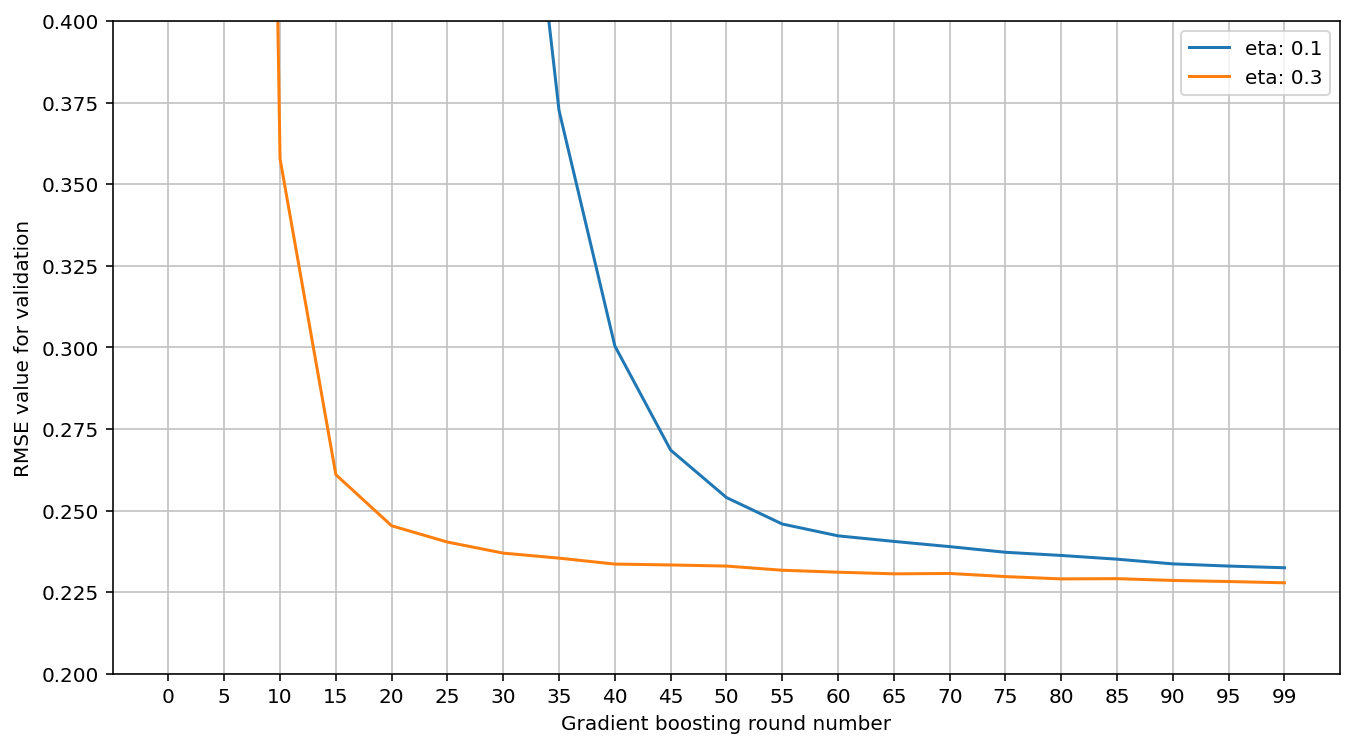

In [33]:
for eta in [0.1, 0.3]:
    df_subset = results[results.eta == eta]
    plt.plot(df_subset.boost_number, df_subset.valid_rmse, label="eta: %s" %eta)

plt.legend()
plt.grid(color='0.75')
plt.xlabel("Gradient boosting round number")
plt.ylabel("RMSE value for validation")
plt.ylim(0.2, 0.4)
plt.show() 

In [34]:
results.sort_values("valid_rmse")[:15]

,boost_number,train_rmse,valid_rmse,eta
20,99,0.13522,0.22784,0.3
19,95,0.13773,0.22823,0.3
18,90,0.14010,0.22856,0.3
16,80,0.14708,0.22903,0.3
17,85,0.14429,0.22911,0.3
15,75,0.15076,0.22975,0.3
13,65,0.15691,0.23059,0.3
14,70,0.15374,0.23070,0.3
12,60,0.16016,0.23109,0.3
11,55,0.16535,0.23169,0.3


As both the plot and the sorted df shows, eta=0.3 gives a lower RMSE.

---
The end of Week 6 assignment

---